In [1]:
import tensorflow as tf

In [2]:
import tensorflow as tf
print(tf.__version__)
tf.config.list_physical_devices('GPU')

2.2.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6501555202438975158
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 429464324287560335
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10598201472
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16542643669194964727
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:09:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5197556130963322286
physical_device_desc: "device: XLA_GPU device"
]


In [4]:
tf.debugging.set_log_device_placement(True)

In [5]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import import_ipynb
import time_data_test_3 as readdata

importing Jupyter notebook from time_data_test_3.ipynb


In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, Masking, Bidirectional,Conv1D, MaxPooling1D
import tensorflow as tf
from sklearn.preprocessing import StandardScaler



<h1> normal data</h1>

In [8]:
#normal data를 그룹핑하고 100개가 넘는 그룹을 골라내기
groupset=[]
over_100_group=[]
for i in range(len(readdata.normal)):
    gb = readdata.normal[i].groupby(['_ws.col.Protocol','ip.src','ip.dst','tcp.srcport'])
    for key, group in gb:
        group = np.asarray(group)
        if len(group)>100:
            over_100_group.append(group)
        else :
            groupset.append(group)

In [9]:
for i in range(len(readdata.normal)):
    gb = readdata.normal[i].groupby(['_ws.col.Protocol','ip.src','ip.dst','tcp.dstport'])
    for key, group in gb:
        group = np.asarray(group)
        if len(group)>100:
            over_100_group.append(group)
        else :
            groupset.append(group)

In [10]:
#normal data 100개가 넘는 그룹 100개씩 잘라서 그룹셋에 넣기
for i in range(len(over_100_group)):
    for j in range(0,len(over_100_group[i]),100):
        groupset.append(over_100_group[i][j:j+100])

In [11]:
len(groupset)

103713

In [12]:
for i in range(len(groupset)):
    groupset[i][:,0]=groupset[i][:,0]-groupset[i][0][0]

In [13]:
#100개가 넘는것은 없는지 확인
for i in range(len(groupset)):
    if len(groupset[i])>100:
        print(i)

In [14]:
X=[]
for i in range(len(groupset)):
    temp=np.delete(groupset[i],[1,2,3,4,5],1)
    num=100-len(temp)
    X.append(np.pad(temp,((0,num),(0,0)),'constant', constant_values=-1))

In [15]:
X_data=np.asarray(X)

In [16]:
len(X_data)

103713

In [17]:
Y_data=[]
for i in range(len(X_data)):
    Y_data.append(0)

In [18]:
len(Y_data)

103713

In [19]:
X_data.shape

(103713, 100, 4)

공격데이터

In [21]:
groupset_a=[]
over_100_group_a=[]
gb = readdata.attack.groupby(['_ws.col.Protocol','ip.src','ip.dst','tcp.srcport'])
for key, group in gb:
    group = np.asarray(group)
    if len(group)>100:
        over_100_group_a.append(group)
    else :
        groupset_a.append(group)


In [22]:
gb = readdata.attack.groupby(['_ws.col.Protocol','ip.src','ip.dst','tcp.dstport'])
for key, group in gb:
    group = np.asarray(group)
    if len(group)>100:
        over_100_group_a.append(group)
    else :
        groupset_a.append(group)


In [25]:
for i in range(len(over_100_group_a)):
    for j in range(0,len(over_100_group_a[i]),100):
        groupset_a.append(over_100_group_a[i][j:j+100])

In [27]:
for i in range(len(groupset_a)):
    groupset_a[i][:,0]=groupset_a[i][:,0]-groupset_a[i][0][0]

In [29]:
X_a=[]
for i in range(len(groupset_a)):
    temp=np.delete(groupset_a[i],[1,2,3,4,5],1)
    num=100-len(temp)
    X_a.append(np.pad(temp,((0,num),(0,0)),'constant', constant_values=-1))

In [31]:
Y_a=[]
for i in range(len(X_a)):
    Y_a.append(1)

In [32]:
X_attack_data=np.asarray(X_a)
Y_attack_data=np.asarray(Y_a)

In [33]:
X_total=np.concatenate((X_data,X_attack_data), axis=0)
#index : 0~891936 까지 normal, 총 891937

In [34]:
X_total.shape

(104072, 100, 4)

In [35]:
Y_total=np.concatenate((Y_data,Y_attack_data), axis=0)

In [36]:
Y_total.shape

(104072,)

In [37]:
# Conv1d 모델을 이용해 특징 맵 추출 후 가중치 부여, LSTM 단일 은닉층을 배치.

def build_model():
    learning_rate = 0.00001
    seq_length = 100
    data_dim = 4
    METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy')
    ]
    model = Sequential()

    model.add(Conv1D(256, 3, activation = 'relu', kernel_regularizer='l2', input_shape=(100, 4)))
    model.add(MaxPooling1D(pool_size=4))    
    model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
    model.add(LSTM(256))  
    model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer='l2'))

    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=learning_rate), metrics=METRICS)
    
    return model

In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [39]:
skf = StratifiedKFold(n_splits=10)
k=10

In [40]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


In [42]:
all_history=[]
all_acc=[]
all_f1=[]
matrix=[]

model =  build_model()
for train_index, test_index in skf.split(X_total,Y_total):
    #print('train_index : ', train_index,'\ntest_index : ',test_index)
    X_train = X_total[train_index]
    y_train = Y_total[train_index]  
    X_test = X_total[test_index]
    y_test = Y_total[test_index]

    sm = SMOTE()
    X_train=np.reshape(X_train,(len(X_train),400))

    X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)
    X_train_oversampled=np.reshape(X_train_oversampled,(len(X_train_oversampled),100,4))
    history =model.fit(X_train_oversampled, y_train_oversampled,epochs=60, batch_size=256, verbose=1 )
    all_history.append(history.history)
    X_test=X_test.astype('float32')
    y_pred = model.predict(X_test)
    y_pred_binary=np.around(y_pred)
    
    acc=accuracy_score(y_test, y_pred_binary)
    all_acc.append(acc)
    
    f1=f1_score(y_test, y_pred_binary)
    all_f1.append(f1)
    
    matrix.append(confusion_matrix(y_test, y_pred_binary))
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
    print(f'Accuracy: {acc}')
    print(f'f-score: {f1}')
    print(f'tn fp fn tp :{tn, fp, fn, tp}')

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Epoch 1/60
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing

730/730 [==============================] - 6s 9ms/step - loss: 0.0657 - accuracy: 1.0000
Epoch 52/60
730/730 [==============================] - 6s 9ms/step - loss: 0.0648 - accuracy: 1.0000
Epoch 53/60
730/730 [==============================] - 6s 9ms/step - loss: 0.0655 - accuracy: 0.9996
Epoch 54/60
730/730 [==============================] - 6s 9ms/step - loss: 0.0630 - accuracy: 1.0000
Epoch 55/60
730/730 [==============================] - 6s 9ms/step - loss: 0.0620 - accuracy: 1.0000
Epoch 56/60
730/730 [==============================] - 6s 9ms/step - loss: 0.0608 - accuracy: 1.0000
Epoch 57/60
730/730 [==============================] - 6s 9ms/step - loss: 0.0677 - accuracy: 0.9983
Epoch 58/60
730/730 [==============================] - 6s 9ms/step - loss: 0.0604 - accuracy: 0.9998
Epoch 59/60
730/730 [==============================] - 6s 9ms/step - loss: 0.0587 - accuracy: 1.0000
Epoch 60/60
730/730 [==============================] - 6s 9ms/step - loss: 0.0582 - accuracy: 1.0000
Ex

730/730 [==============================] - 6s 9ms/step - loss: 0.0243 - accuracy: 1.0000
Epoch 60/60
730/730 [==============================] - 6s 9ms/step - loss: 0.0242 - accuracy: 1.0000
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/dev

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Accuracy: 0.9992312866339963
f-score: 0.8787878787878789
tn fp fn tp :(10370, 1, 7, 29)
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executin

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Accuracy: 1.0
f-score: 1.0
tn fp fn tp :(10371, 0, 0, 36)
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Epoch 1/60
730/730 [=====================

Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Epoch 1/60
730/730 [==============================] - 6s 9ms/step - loss: 0.0159 - accuracy: 1.0000
Epoch 2/60
730/730 [==============================] - 6s 9ms/step - loss: 0.0162 - accuracy: 0.9999
Epoch 3/60
730/730 [==============================] - 6s 9ms/step - loss: 0.0158 - accuracy: 1.0000
Epoch 4/60
730/730 [==============================] - 6s 9ms/step - loss: 0.0158 - accuracy: 1.0000
Epoch 5/60
730/730 [==============================] - 6s 9ms/step - loss: 0.0158 - accuracy: 1.0000
Epoch 

Epoch 1/60
730/730 [==============================] - 6s 9ms/step - loss: 0.0165 - accuracy: 0.9997
Epoch 2/60
730/730 [==============================] - 6s 9ms/step - loss: 0.0149 - accuracy: 1.0000
Epoch 3/60
730/730 [==============================] - 6s 9ms/step - loss: 0.0148 - accuracy: 1.0000
Epoch 4/60
730/730 [==============================] - 6s 9ms/step - loss: 0.0147 - accuracy: 1.0000
Epoch 5/60
730/730 [==============================] - 6s 9ms/step - loss: 0.0147 - accuracy: 1.0000
Epoch 6/60
730/730 [==============================] - 6s 9ms/step - loss: 0.0150 - accuracy: 0.9999
Epoch 7/60
730/730 [==============================] - 6s 9ms/step - loss: 0.0150 - accuracy: 0.9999
Epoch 8/60
730/730 [==============================] - 6s 9ms/step - loss: 0.0147 - accuracy: 1.0000
Epoch 9/60
730/730 [==============================] - 6s 9ms/step - loss: 0.0147 - accuracy: 1.0000
Epoch 10/60
730/730 [==============================] - 6s 9ms/step - loss: 0.0147 - accuracy: 1.0000

In [44]:
print(all_acc)
print(all_f1)
for i in range(k):
    print(matrix[i][0][0],matrix[i][0][1],matrix[i][1][0],matrix[i][1][1])

[0.9995196003074558, 1.0, 0.9999039108292496, 0.9995195541462477, 0.9992312866339963, 1.0, 1.0, 1.0, 1.0, 0.9980782165849909]
[0.9350649350649352, 1.0, 0.9855072463768115, 0.9350649350649352, 0.8787878787878789, 1.0, 1.0, 1.0, 1.0, 0.6153846153846153]
10367 5 0 36
10372 0 0 36
10372 0 1 34
10366 5 0 36
10370 1 7 29
10371 0 0 36
10371 0 0 36
10371 0 0 36
10371 0 0 36
10371 0 20 16


In [45]:
print(sum(all_acc)/10)
print(sum(all_f1)/10)
for i in range(k):
    print(matrix[i][0][0],matrix[i][0][1],matrix[i][1][0],matrix[i][1][1])

0.9996252568501941
0.9349809610679175
10367 5 0 36
10372 0 0 36
10372 0 1 34
10366 5 0 36
10370 1 7 29
10371 0 0 36
10371 0 0 36
10371 0 0 36
10371 0 0 36
10371 0 20 16


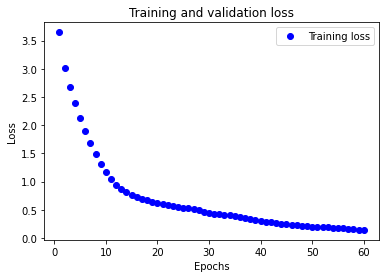

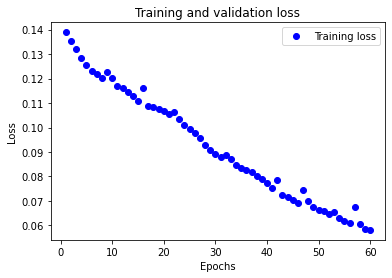

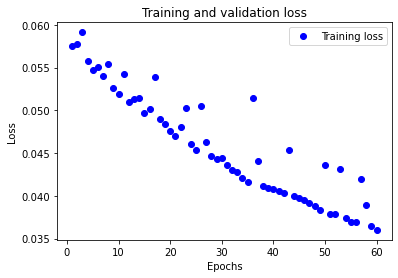

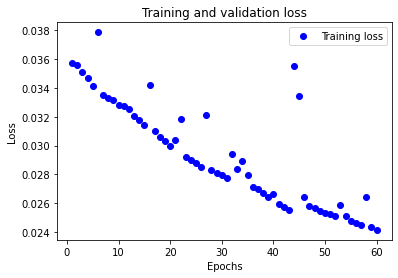

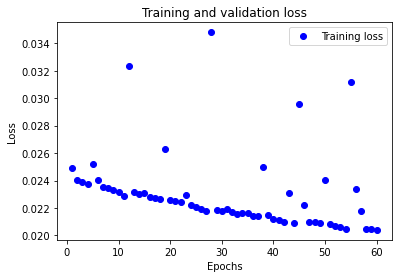

In [46]:
for i in range(5):
    loss =all_history[i]['loss']
    #val_loss = all_history[i]['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')  # ‘bo’는 파란색 점을 의미합니다.
    #plt.plot(epochs, val_loss, 'b', label='Validation loss') # ‘b’는 파란색 실선을 의미합니다.
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [47]:
test_data=pd.read_csv('test_dataset_01.csv',error_bad_lines=False)

b'Skipping line 1000426: expected 22 fields, saw 23\n'
b'Skipping line 1279004: expected 22 fields, saw 23\n'
b'Skipping line 3023273: expected 22 fields, saw 27\n'
b'Skipping line 3074890: expected 22 fields, saw 27\n'
b'Skipping line 3460738: expected 22 fields, saw 23\n'


In [48]:
test_data=test_data.iloc[:,0:9]

In [49]:
test_data.columns=['_ws.col.UTCtime',"_ws.col.Protocol","ip.src","ip.dst","tcp.srcport","tcp.dstport","tcp.len","tcp.seq","tcp.ack"]

In [50]:
test_data=test_data.sort_values(by='_ws.col.UTCtime')

In [51]:
test_data['_ws.col.UTCtime']=pd.to_datetime(test_data['_ws.col.UTCtime'])
test_data['_ws.col.UTCtime']=test_data['_ws.col.UTCtime'].astype(np.int64)// 10**9

In [52]:
test_data['_ws.col.UTCtime']=test_data['_ws.col.UTCtime']-test_data.iloc[0,0]

In [53]:
test_data= test_data.dropna(axis=0) #결측값 삭제
test_data=test_data.astype({"_ws.col.UTCtime":'int','tcp.srcport': 'int','tcp.dstport': 'int','tcp.len': 'int','tcp.seq':'int','tcp.ack': 'int'})

In [55]:
groupset=[]
over_100_group=[]
gb = test_data.groupby(['_ws.col.Protocol','ip.src','ip.dst','tcp.srcport'])
for key, group in gb:
    group = np.asarray(group)
    if len(group)>100:
        over_100_group.append(group)
    else :
        groupset.append(group)

In [56]:
gb = test_data.groupby(['_ws.col.Protocol','ip.src','ip.dst','tcp.dstport'])
for key, group in gb:
    group = np.asarray(group)
    if len(group)>100:
        over_100_group.append(group)
    else :
        groupset.append(group)

In [57]:
for i in range(len(over_100_group)):
    for j in range(0,len(over_100_group[i]),100):
        groupset.append(over_100_group[i][j:j+100])

In [58]:
len(groupset)

409211

In [59]:
for i in range(len(groupset)):
    groupset[i][:,0]=groupset[i][:,0]-groupset[i][0][0]

In [61]:
X=[]
for i in range(len(groupset)):
    temp=np.delete(groupset[i],[1,2,3,4,5],1)
    num=100-len(temp)
    X.append(np.pad(temp,((0,num),(0,0)),'constant', constant_values=-1))

In [62]:
X_data=np.asarray(X)

In [64]:
X_data=X_data.astype('float32')

In [65]:
predict =model.predict(X_data)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ConcatV2 in device /job:localhost/replica:0/task:0/device:GPU:0


In [66]:
print(X_data.shape, predict.shape)

(409211, 100, 4) (409211, 1)


In [67]:
y_pred_binary=np.around(predict)

In [68]:
pred_attack_ix=[]
for i in range(len(y_pred_binary)):
    if y_pred_binary[i]==1:
        pred_attack_ix.append(i)

In [69]:
print(len(pred_attack_ix))

175


In [71]:
import csv
f = open('network.csv','w', newline='')
wr = csv.writer(f)

In [72]:
for index in pred_attack_ix:
    for i in range(len(groupset[index])):
        wr.writerow([groupset[index][i][2],groupset[index][i][3],groupset[index][i][4],groupset[index][i][5],groupset[index][i][1]])

In [73]:
f.close()